**Name:** LI XINYAN

**EID:** 55670594

# CS5489 - Tutorial 3
## Gender Classification from Face Images

In this tutorial you will train a classifier to predict whether a face image is male or female.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
random.seed(100)

## 1. Loading Data and Pre-processing
We first need to load the images.  Download `photos-bw.zip` and put it in the same directory as this ipynb file.  **Do not unzip the file.** Then run the following cell to load the images.

In [2]:
imgdata = []
genders = []

# load the zip file
filename = 'photos-bw.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "photos-bw/*.png"):
        print("loading", name)
        # open file in memory, and parse as an image
        myfile = zfile.open(name)
        img = matplotlib.image.imread(myfile)
        myfile.close()
        
        # append to data
        imgdata.append(img)
        genders.append( int(name[len("photos-bw/")] == 'm') )  # 0 is female, 1 is male
        
zfile.close()
imgsize = img.shape
print("DONE: loaded {} images".format(len(imgdata)))

loading photos-bw/f-039-01.png
loading photos-bw/f-040-01.png
loading photos-bw/f-041-01.png
loading photos-bw/f-042-01.png
loading photos-bw/f-043-01.png
loading photos-bw/f1-001-0.png
loading photos-bw/f1-002-0.png
loading photos-bw/f1-003-0.png
loading photos-bw/f1-004-0.png
loading photos-bw/f1-005-0.png
loading photos-bw/f1-006-0.png
loading photos-bw/f1-007-0.png
loading photos-bw/f1-008-0.png
loading photos-bw/f1-009-0.png
loading photos-bw/f1-010-0.png
loading photos-bw/f1-011-0.png
loading photos-bw/f1-012-0.png
loading photos-bw/f1-013-0.png
loading photos-bw/f1-014-0.png
loading photos-bw/f1-015-0.png
loading photos-bw/m-063-01.png
loading photos-bw/m-064-01.png
loading photos-bw/m-065-01.png
loading photos-bw/m-067-01.png
loading photos-bw/m-069-01.png
loading photos-bw/m-070-01.png
loading photos-bw/m-073-01.png
loading photos-bw/m-074-01.png
loading photos-bw/m-075-01.png
loading photos-bw/m-077-01.png
loading photos-bw/m-083-01.png
loading photos-bw/m-085-01.png
loading 

Each image is a 45x40 array of pixel values.  Run the below code to show an example:

(45, 40)


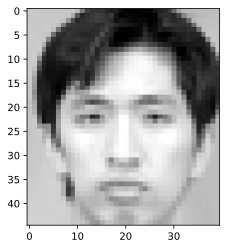

In [3]:
print(img.shape)
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.show()

Run the below code to show all the images!

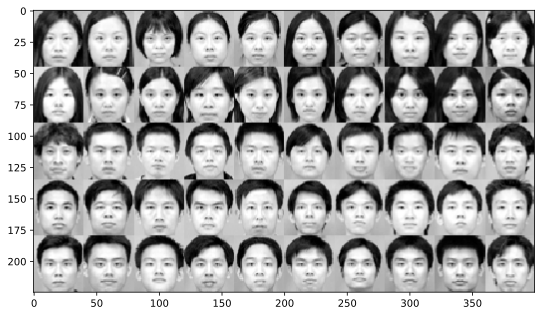

In [4]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(X[i])
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

plt.figure(figsize=(9,9))
plt.imshow(image_montage(imgdata), cmap='gray', interpolation='nearest')
plt.show()

Each image is a 2d array, but the classifier algorithms work on 1d vectors. Run the following code to convert all the images into 1d vectors by flattening.  The result should be a matrix where each row is a flattened image.

In [5]:
X = empty((50, prod(imgdata[0].shape))) # create empty array
for i,img in enumerate(imgdata):
    X[i,:] = ravel(img)           # for each image, turn it into a vector
Y = asarray(genders)  # convert list to numpy array
print(X.shape)
print(Y.shape)

(50, 1800)
(50,)


In [6]:
print(X)
print(Y)

[[0.7647059  0.7647059  0.7647059  ... 0.08235294 0.08235294 0.09411765]
 [0.76862746 0.76862746 0.76862746 ... 0.19215687 0.19215687 0.26666668]
 [0.82745099 0.82352942 0.81960785 ... 0.66666669 0.72549021 0.71764708]
 ...
 [0.78431374 0.78039217 0.78039217 ... 0.66274512 0.67058825 0.67843139]
 [0.68627453 0.68235296 0.68235296 ... 0.67058825 0.67058825 0.65882355]
 [0.79215688 0.78823531 0.78823531 ... 0.72941178 0.73725492 0.74117649]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


Next we will shift the pixel values so that gray is 0.0, black is -0.5 and white is 0.5.

In [7]:
print("Before: min={}, max={}".format(X.min(), X.max()))
X -= 0.5
print("After:  min={}, max={}".format(X.min(), X.max()))

Before: min=0.0, max=1.0
After:  min=-0.5, max=0.5


[[ 0.2647059   0.2647059   0.2647059  ... -0.41764706 -0.41764706
  -0.40588235]
 [ 0.26862746  0.26862746  0.26862746 ... -0.30784313 -0.30784313
  -0.23333332]
 [ 0.32745099  0.32352942  0.31960785 ...  0.16666669  0.22549021
   0.21764708]
 ...
 [ 0.28431374  0.28039217  0.28039217 ...  0.16274512  0.17058825
   0.17843139]
 [ 0.18627453  0.18235296  0.18235296 ...  0.17058825  0.17058825
   0.15882355]
 [ 0.29215688  0.28823531  0.28823531 ...  0.22941178  0.23725492
   0.24117649]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


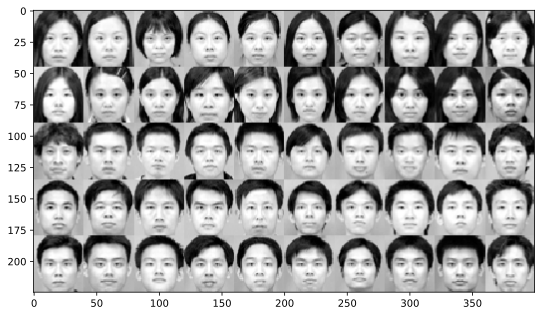

In [8]:
print(X)
print(Y)
plt.figure(figsize=(9,9))
plt.imshow(image_montage(X, (45, 40)), cmap='gray', interpolation='nearest')
plt.show()

Finally, split the dataset into a training set and testing set. We select 80% for training and 20% for testing.

In [9]:
# randomly split data into 80% train and 20% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.80, test_size=0.20, random_state=4487)

print(trainX.shape)
print(testX.shape)

(40, 1800)
(10, 1800)


In [10]:
# compute the average image for later
avgX = mean(X,axis=0)

[0.27717648 0.27662746 0.27498041 ... 0.08384315 0.1007059  0.13372551]


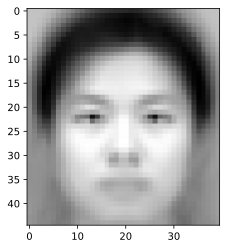

In [11]:
print(avgX)
plt.imshow(avgX.reshape(45, 40), cmap='gray', interpolation='nearest')
plt.show()

# 2. Logistic Regression
Train a logistic regression classifier.  Use cross-validation to select the best C parameter.

w= [[0.00034914 0.0003924  0.00047547 ... 0.01253778 0.00990326 0.00948138]]
b= [-0.02011288]
C = [0.01082637]


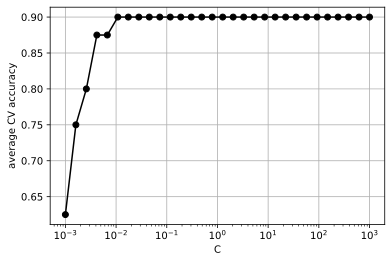

In [12]:
### INSERT YOUR CODE HERE

# LR classifier using Cross-Validation
logreg = linear_model.LogisticRegressionCV(Cs=logspace(-3, 3, 30), cv=5, n_jobs=-1)
logreg.fit(trainX, trainY)

print("w=", logreg.coef_)
print("b=", logreg.intercept_)
print("C =", logreg.C_)

# calculate the average score for each C
avgscores = mean(logreg.scores_[1],0)
plt.semilogx(logreg.Cs_, avgscores, 'ko-')
plt.xlabel('C')
plt.ylabel('average CV accuracy')
plt.grid(True);

Use the learned model to predict the genders for the training and testing data. What is the accuracy on the training set? What is the accuracy on the testing set?

In [13]:
### INSERT YOUR CODE HERE

# accuracy - training set
predYtrain = logreg.predict(trainX)
acc = metrics.accuracy_score(trainY, predYtrain)
print("train accuracy=", acc)

# accuracy - testing set
predYtest = logreg.predict(testX)
acc = metrics.accuracy_score(testY, predYtest)
print("test accuracy=", acc)

train accuracy= 0.9
test accuracy= 0.8


### Analyzing the classifier
Run the below code to show the hyperplane parameter $\mathbf{w}$ as an image.  

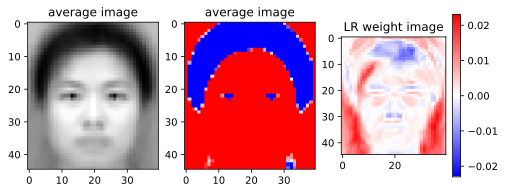

In [14]:
# logreg is the learned logistic regression model
wimg = logreg.coef_.reshape(imgsize)      # get the w and reshape into an image
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#0000FF", "#FFFFFF", "#FF0000"])
mm = max(wimg.max(), -wimg.min())
plt.figure(figsize=(8,3))

plt.subplot(1,3,1)
plt.title('average image')
plt.imshow(avgX.reshape(imgsize), cmap='gray')

plt.subplot(1,3,2)
plt.title('average image')
plt.imshow(avgX.reshape(imgsize), cmap=mycmap, vmin=-mm, vmax=mm)

plt.subplot(1,3,3)
plt.imshow(wimg, interpolation='nearest', cmap=mycmap, vmin=-mm, vmax=mm)
plt.colorbar()
plt.title("LR weight image")
plt.show()

In [15]:
# check the avg img
import numpy as np

predYavg = logreg.predict(np.array([avgX]))
print(predYavg)

[1]


Recall that the classifier prediction is based on the sign of the function $f(\mathbf{x}) = \mathbf{w}^T\mathbf{x}+b = \sum_{i=1}^P w_ix_i + b$.  Here each $x_i$ is a pixel in the face image, and $w_i$ is the corresponding weight.  Hence, the function is multiplying face image by the weight image, and then summing over all pixels.

In order for $f(\mathbf{x})$ to be positive, then the positive values of the weight image (red regions) should match the positive values in the face image (white pixels), and the negative values of the weight image (blue regions) should be matched with negative values in the face image (black pixels).

Hence, we can have the following interpretation:
<table>
<tr><th>Class</th><th>red regions (positive weights)</th><th>blue regions (negative weights)</th><th>white regions (weights near 0)</th></tr>
<tr><td>+1 class (male)</td><td>white pixels in face image</td><td>black pixels in face image</td><td>region not important</td></tr>
<tr><td>-1 class (female)</td><td>black pixels in face image</td><td>white pixels in face image</td><td>region not important</td></tr>
</table>
  
_Looking at the weight image, what parts of the face image is the classifier looking at to determine the gender?  Does it make sense?_

- **INSERT YOUR ANSWER HERE**
1. The classifier focuses on the shoulder-length hair (the lift and right bottom corner of the image), the bangs on both sides of one's head, the forehead, the eyebrows, and the nostril.

2. It makes sense and consists with our intuition: the females are more likely to have shoulder-length hair, or have bangs covering both sides of her head (less empty area in the forehead), smaller nostril, and sparse eyebrows.

Now let's look at the misclassified faces in the test set.  Run the below code to show the misclassifed and correctly classified faces.

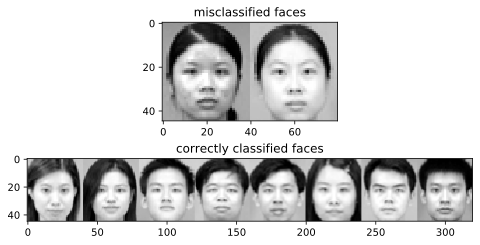

In [16]:
# predYtest are the class predictions on the test set.

# find misclassified test images
inds = where(predYtest != testY) # get indices of misclassified test images
# make a montage
badimgs = image_montage(testX[inds], imsize=imgsize)

# find correctly classified test images
inds = where(predYtest == testY)
goodimgs = image_montage(testX[inds], imsize=imgsize)
    
plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
plt.imshow(badimgs, cmap='gray', interpolation='nearest')
plt.title('misclassified faces')
plt.subplot(2,1,2)
plt.imshow(goodimgs, cmap='gray', interpolation='nearest')
plt.title('correctly classified faces')
plt.show()

_Why did the classifier make incorrect predictions on the misclassified faces?_
- **INSERT YOUR ANSWER HERE**

It's obvious that the misclassified faces both belong to female and they do not have a sholder-length hair or bangs. Due to the fact that the classifier pays most attention to those feature rigions, the above faces are misclassified.

# 3. Support Vector Machine
Now train a support vector machine (SVM) on the same training and testing data.  Use cross-validation to select the best $C$ parameter.

{'C': array([1.00000000e-03, 1.61026203e-03, 2.59294380e-03, 4.17531894e-03,
       6.72335754e-03, 1.08263673e-02, 1.74332882e-02, 2.80721620e-02,
       4.52035366e-02, 7.27895384e-02, 1.17210230e-01, 1.88739182e-01,
       3.03919538e-01, 4.89390092e-01, 7.88046282e-01, 1.26896100e+00,
       2.04335972e+00, 3.29034456e+00, 5.29831691e+00, 8.53167852e+00,
       1.37382380e+01, 2.21221629e+01, 3.56224789e+01, 5.73615251e+01,
       9.23670857e+01, 1.48735211e+02, 2.39502662e+02, 3.85662042e+02,
       6.21016942e+02, 1.00000000e+03])}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.4s finished


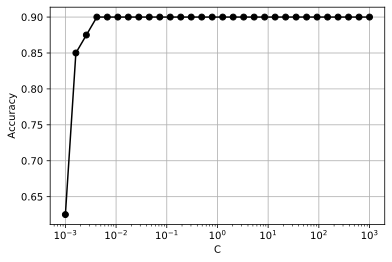

In [17]:
### INSERT YOUR CODE HERE

# setup the list of C-parameters to try, C: slack
paramgrid = {'C': logspace(-3, 3, 30)}
print(paramgrid)

# setup the cross-validation object
svmcv = model_selection.GridSearchCV(svm.SVC(kernel='linear'), paramgrid, cv=5, n_jobs=-1, verbose=True)
svmcv.fit(trainX, trainY);

# show test error, make a plot
C_list = []
score_list = []
for m,p in zip(svmcv.cv_results_['mean_test_score'], svmcv.cv_results_['params']):
              C_list.append(p['C'])
              score_list.append(m)
plt.figure()
plt.semilogx(C_list, score_list, 'ko-')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.grid(True)

Calculate the training and test accuracy for the SVM classifier.

In [18]:
### INSERT YOUR CODE HERE
best_model = svmcv.best_estimator_

# accuracy - training set
predYtrain = best_model.predict(trainX)
acc = metrics.accuracy_score(trainY, predYtrain)
print("train accuracy=", acc)

# accuracy - testing set
predYtest = best_model.predict(testX)
acc = metrics.accuracy_score(testY, predYtest)
print("test accuracy=", acc)

train accuracy= 0.9
test accuracy= 0.8


Similar to before, plot an image of the hyperplane parameters $w$, and view the misclassified and correctly classified test images.

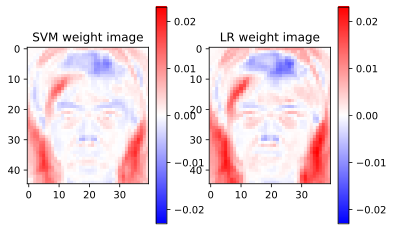

In [19]:
### INSERT YOUR CODE HERE

w = best_model.coef_[0]

plt.subplot(1,2,1)
wimg = w.reshape(imgsize)
plt.imshow(wimg, interpolation='nearest', cmap=mycmap, vmin=-mm, vmax=mm)
plt.colorbar()
plt.title("SVM weight image")


plt.subplot(1,2,2)
wimg = logreg.coef_.reshape(imgsize)
plt.imshow(wimg, interpolation='nearest', cmap=mycmap, vmin=-mm, vmax=mm)
plt.colorbar()
plt.title("LR weight image")
plt.show()

_Are there any differences between the $w$ for logistic regressiona and the $w$ for SVM?  Is there any interpretation for the differences?_

- **INSERT YOUR ANSWER HERE**

1. The weights in LR model are larger than that of an SVM model (both red and blue are darker in the LR weight image);
2. There are more blue regions in the SVM weight image and the blue regions tend to be evenly distributed in the image (even though there are light blue);

The above observations suggest that an SVM model is more cautious about its decision and tend to choose smaller weights. But the LR model is more sure about its decision, which might be easier to cause overfitting.

# 4. Classifying cropped faces
It seems that the hair around the face and forehead are discriminative enough to perform gender classifixation. Now try to perform the same task but only focusing on the face image, and not the hair.

First, we define a mask over the face.

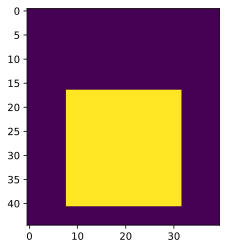

In [20]:
imgmask = full((img.shape), False)
imgmask[17:41,8:32] = True
masksize = (24,24)
# imgmask[18:40,11:29] = True
# masksize = (22,18)
plt.imshow(imgmask)

Next we crop out the face image to create the new inputs.  The vectors are now 576-dim, and corresponding images are 24x24.

In [21]:
Xm = X[:,imgmask.ravel()]
Xm.shape

(50, 576)

Here are the cropped images.

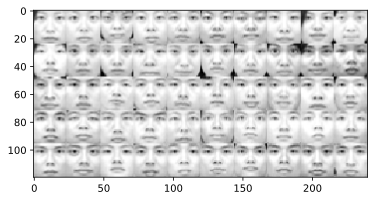

In [22]:
plt.imshow(image_montage(Xm, imsize=masksize), cmap='gray', interpolation='nearest')

Generate the same training/test split as before

In [23]:
# randomly split data into 80% train and 20% test set
trainXm, testXm, trainY, testY = \
  model_selection.train_test_split(Xm, Y, 
  train_size=0.80, test_size=0.20, random_state=4487)

print(trainXm.shape)
print(testXm.shape)

(40, 576)
(10, 576)


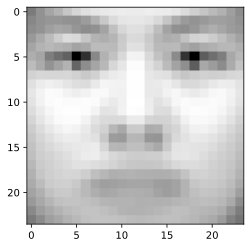

In [24]:
avgXm = avgX[imgmask.ravel()]
plt.imshow(avgXm.reshape(masksize), cmap='gray', interpolation='nearest')

Now train logistic regression and SVM classifiers on the new cropped images.

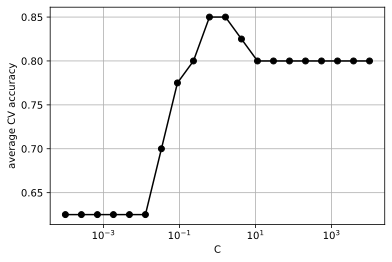

In [25]:
### INSERT YOUR CODE HERE

# LR classifier
LRC = linear_model.LogisticRegressionCV(Cs=logspace(-4, 4, 20), cv=5, n_jobs=-1)
LRC.fit(trainXm, trainY)

# calculate the average score for each C
avgscores = mean(LRC.scores_[1],0)
plt.semilogx(LRC.Cs_, avgscores, 'ko-')
plt.xlabel('C')
plt.ylabel('average CV accuracy')
plt.grid(True);

In [26]:
### INSERT YOUR CODE HERE

# SVM classifier
# paramgrid = {'C': logspace(-4, 4, 200)}
# print(paramgrid)

# # setup the cross-validation object
# svmcv = model_selection.GridSearchCV(svm.SVC(kernel='linear'), paramgrid, cv=5, n_jobs=-1, verbose=True)
# svmcv.fit(trainXm, trainY);

# C_list = []
# score_list = []
# for m,p in zip(svmcv.cv_results_['mean_test_score'], svmcv.cv_results_['params']):
#               C_list.append(p['C'])
#               score_list.append(m)
# plt.figure()
# plt.semilogx(C_list, score_list, 'ko-')
# plt.xlabel('C')
# plt.ylabel('Accuracy')
# plt.grid(True)

# # Select best model
# SVMC = svmcv.best_estimator_

SVMC = svm.SVC(kernel='linear', C=2)
SVMC.fit(trainXm, trainY);

Compute the train/test accuracies of the two classifiers.

In [27]:
### INSERT YOUR CODE HERE

# test LR
predY = LRC.predict(testXm)
acc = metrics.accuracy_score(testY, predY)
print("LR test accuracy =%9f" % acc)

LR test accuracy = 0.900000


In [28]:
### INSERT YOUR CODE HERE

# test SVM
predY = SVMC.predict(testXm)
acc = metrics.accuracy_score(testY, predY)
print("SVM test accuracy =%9f" % acc)

SVM test accuracy = 0.900000


Compare the classification performance? Which performs better and why?

- **INSERT YOUR ANSWER HERE**

- The LR and SVM classifier achieve the same classification accuracy. I think the reason is that the size of the test set is too small to distinguish between the two classifiers (or the size of the train set is too small to provide sufficient information to train a mature classifier).

Visualize the weights as an image and interpret what discriminative information each classifier is using.

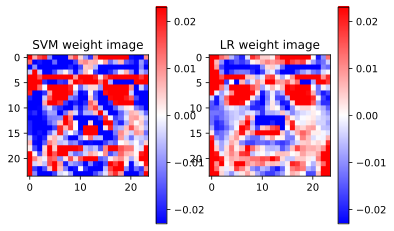

In [29]:
### INSERT YOUR CODE HERE

plt.subplot(1,2,1)
w = SVMC.coef_[0]/4
wimg = w.reshape(masksize)
plt.imshow(wimg, interpolation='nearest', cmap=mycmap, vmin=-mm, vmax=mm)
plt.colorbar()
plt.title("SVM weight image")


plt.subplot(1,2,2)
w = LRC.coef_[0]/4
wimg = w.reshape(masksize)
plt.imshow(wimg, interpolation='nearest', cmap=mycmap, vmin=-mm, vmax=mm)
plt.colorbar()
plt.title("LR weight image")
plt.show()

# Visualize the weights as an image and interpret what discriminative information each classifier is using.

1. Both LR and SVM classifier use the information of the eye, the eyebrows, the nose, and the cheeks.

2. The LR model puts some of its focus to the corner of the image (corners are mostly covered by red color), maybe it thinks female should have a smaller face (since the corner is occupied by hair and bangs).

3. This time, the SVM has a darker color than before, maybe it suggests that SVM is more confident when focusing on the mask area than on the whole image.